<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_ARIMA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ライブラリインストール
install.packages( "tidyverse" )
install.packages( "fable" )
install.packages( "feasts" )
install.packages( "urca" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘progressr’, ‘anytime’, ‘numDeriv’, ‘fabletools’, ‘Rcpp’, ‘tsibble’, ‘distributional’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘slider’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は場合分けをせず、時系列分析します。

# 手順１　データの収集


*　[データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [5]:
# 該当リポジトリを変数に格納
c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" ) -> repo
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/population_jp_year.csv" )) -> popURL

# ライブラリの読み込み
library( readr )
library( fable )

# ネット上のファイル読み込み
popURL |>
    read_csv( show_col_types = FALSE ) |>
    # ＴＳＩＢＢＬＥライブラリに変換
    as_tsibble( index = Year ) -> pop_tsibble


# 手順２　データの可視化

まず、データをプロットしてみます。

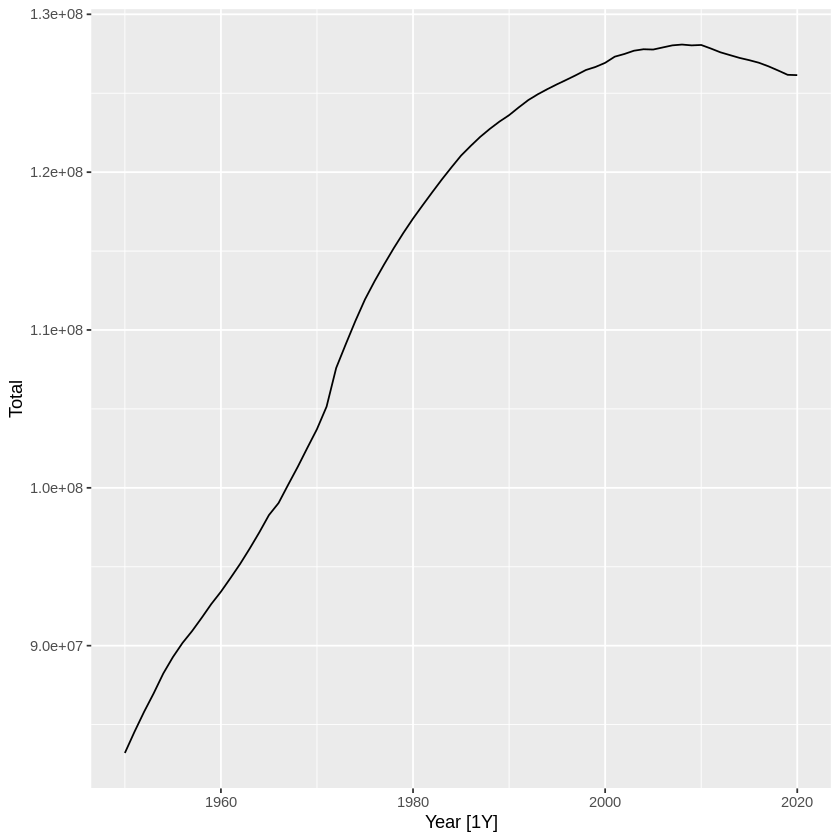

In [ ]:
# ライブラリの読み込み
library( ggplot2 )

# 総人口のグラフ
pop_tsibble |>
autoplot( Total )

次に、自己相関を確認してみます。

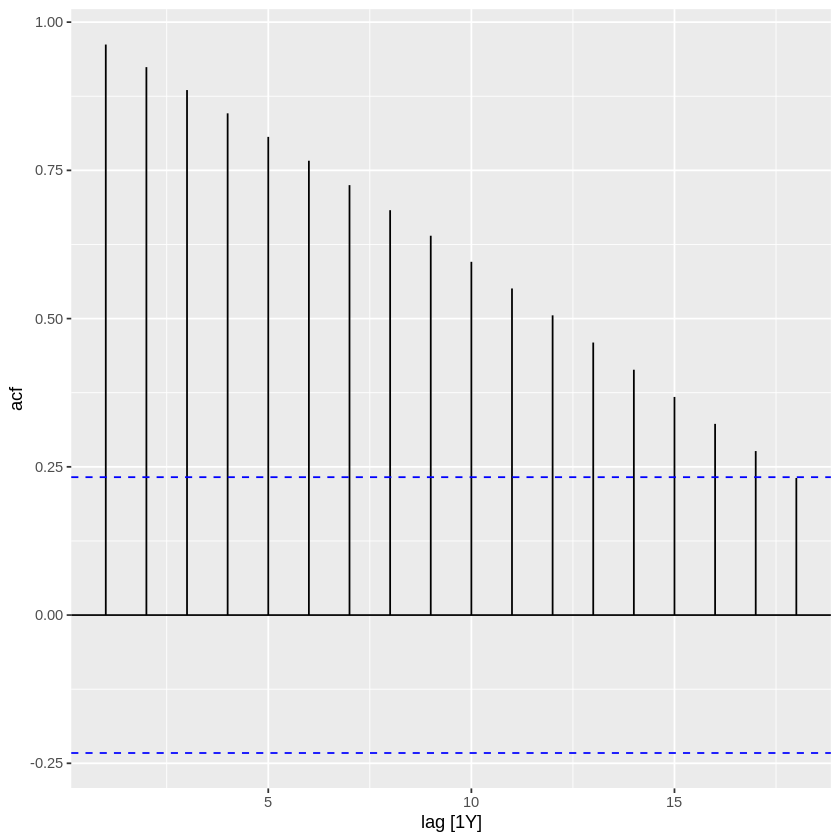

In [ ]:
# ライブラリの読み込み
library( feasts )

# 自己相関のグラフ
pop_tsibble |>
    ACF( Total ) |>
    autoplot()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

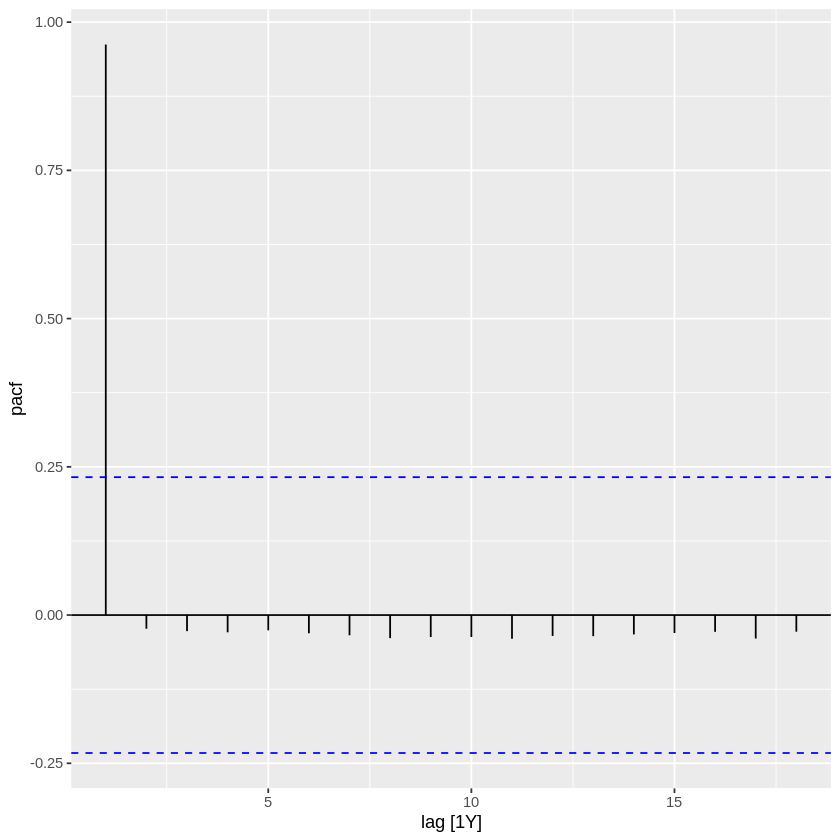

In [ ]:
# 偏自己相関のグラフ
pop_tsibble |>
    PACF( Total ) |>
    autoplot()

# 手順３　学習データと予測データの分類

２０１５年までのデータを学習データとし、その後５年間のデータを予測データとします。

In [ ]:
# 学習データと予測データ
5 -> prow_test
pop_tsibble |> nrow() - prow_test -> prow_train
pop_tsibble |> tail( n = prow_test ) -> pop_test
pop_tsibble |> head( n = prow_train ) -> pop_train

# 手順４　ＡＲＩＭＡモデルによる予測

まず、学習データを使ってＡＲＩＭＡモデルを推定します。

In [ ]:
# ＡＲＩＭＡモデルの推定
pop_train |>
    model( arima = ARIMA( Total, ic = "aic" )) -> pop_arima
pop_arima

arima
<model>
"<ARIMA(0,2,1)>"


では、ＡＲＩＭＡ（０，２，１）が推定されたので、予測してみます。

In [ ]:
# ＡＲＩＭＡによる予測
pop_arima |>
    forecast(xreg = pop_test$Total,
             h = "5 years") -> pop_arima_f
pop_arima_f

.model,Year,Total,.mean
<chr>,<dbl>,<dist>,<dbl>
arima,2016,"N(1.3e+08, 4e+10)",126940780
arima,2017,"N(1.3e+08, 1.5e+11)",126786560
arima,2018,"N(1.3e+08, 3.8e+11)",126632340
arima,2019,"N(1.3e+08, 7.5e+11)",126478120
arima,2020,"N(1.3e+08, 1.3e+12)",126323900


# 手順５　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast,DMBM,DMBH,DLBM,DLBH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,126933000,126940780,126838000,126864000,126912000,126938000
2017,126706000,126786560,126532000,126605000,126704000,126777000
2018,126443000,126632340,126177000,126315000,126441000,126580000
2019,126167000,126478120,125773000,125998000,126125000,126351000
2020,126146000,126323900,125325000,125658000,125761000,126094000


Plot variable not specified, automatically selected `.vars = Total`


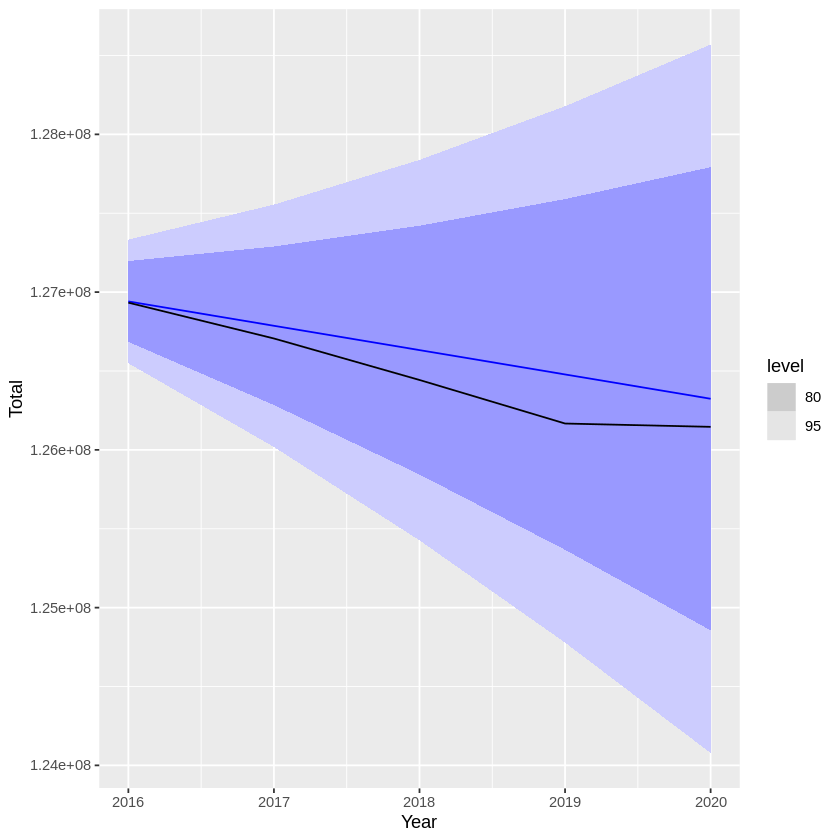

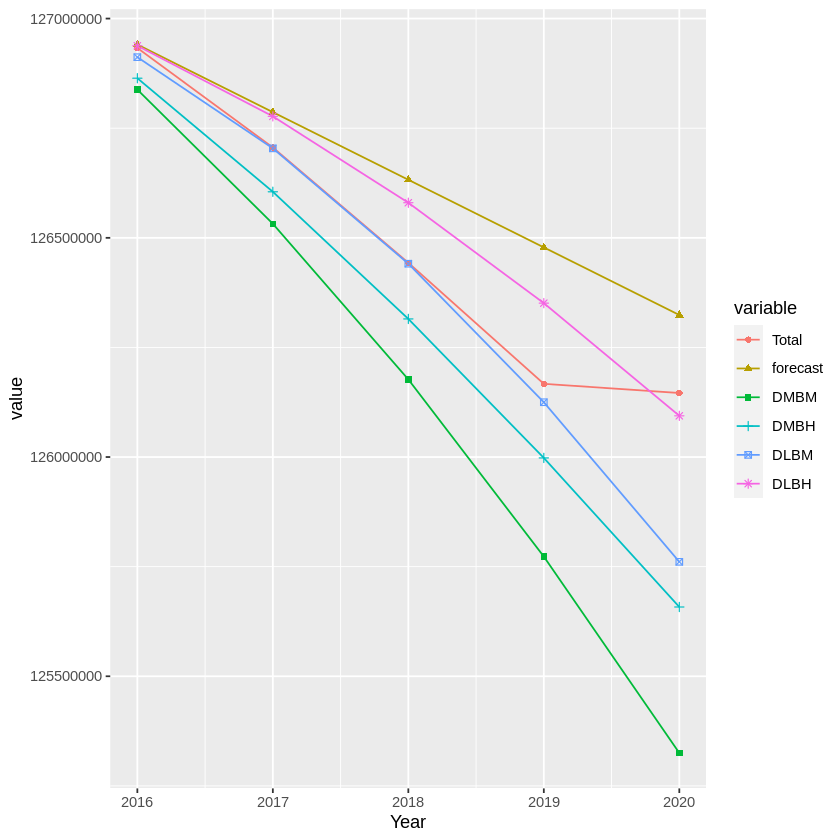

In [ ]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
repo |> paste0( c( "main/data/forecast_ipss.csv" )) -> ipssURL

# ネット上のファイル読み込み
ipssURL |>
    read_csv( show_col_types = FALSE ) |>
    # ＴＳＩＢＢＬＥライブラリに変換
    as_tsibble( index = Year ) -> ipss_test

# ライブラリの読み込み
library( dplyr )

# ＡＲＩＭＡモデル予測をはforecast
# 実データがTotal
# 社人研の結果は、例えば死亡中位出生中位だとDMBM
pop_arima_f |>
    as.data.frame() |>
    select( Year, "forecast" = .mean ) |>
    inner_join( pop_test, by = "Year" ) |>
    inner_join( ipss_test, by = "Year" )|>
    select( Year,
            Total,
            forecast,
            DMBM,
            DMBH,
            DLBM,
            DLBH ) -> join_test
join_test

# ライブラリの読み込み
library( reshape2 )

join_test |>
    melt(id="Year",measure=c( "Total",
                              "forecast",
                              "DMBM",
                              "DMBH",
                              "DLBM",
                              "DLBH")) -> join_plot

#描画
pop_arima_f |> autoplot() +
    autolayer( pop_test )

ggplot( join_plot,
        aes(x = Year,
            y = value,
            shape = variable,
            colour = variable,
            group = variable )) +
geom_line() +
geom_point()

どうやら、実データより２０万人弱、高く予測してしまったようです。  
人口変動の要因は一つではないので、もう少し細かいモデルが必要のようです。

# 次のステップ



*   同じ事をPythonでやってみる。　->　[Ｐｙｔｈｏｎ_人口推計_その１](https://colab.research.google.com/drive/1--2tl9CaoS7YWa9YM9-K7kTxgimLVrVx?usp=sharing)
*   色んなモデルを当てはめてみる　->　こちら
*   人口方程式の考え方に沿ってみる　->　[Ｒ_人口推計_その２](https://colab.research.google.com/drive/1EF1ngKafPHpPy1QcZHBZ_8wmvGunLWbK?usp=sharing)

